<div style="display: flex; text-align:center; background-color: rgb(153,102,153);" >
<h1 style="margin: auto; padding: 30px; ">Détectez des faux billets avec Python <br></h1>

# Scénario

Je suis consultat DA dans une entreprise spécialisée dans la Data. Elle a décroché une prestation au sein de la ONCFM

Ma mission :

Mettre en place une modélisation capable d'identifier automatiquement les vrais des faux billets

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">1 - Importation des librairies et fichiers</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import RobustScaler
from sklearn import cluster, metrics
from sklearn import decomposition
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,classification_report, accuracy_score
from sklearn.metrics import  adjusted_rand_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix


import scipy.stats as st
from scipy.stats import t, shapiro

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf 
import statsmodels.api as sma
import statsmodels.stats.api as sms

from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
billets = pd.read_csv("billets.csv",sep=';')

# Affichage des nombres : séparateur des milliers, et réduction du nombre de décimales
pd.options.display.float_format = '{:,.2f}'.format

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">2 - Nettoyage et exploration des données </h2>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.1- Billets </h3>

In [3]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Nous disposons actuellement de six informations géométriques sur un billet :

- length : la longueur du billet (en mm) ;

- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;

- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;

- margin_up : la marge entre le bord supérieur du billet et l'image de
    celui-ci (en mm) ;

- margin_low : la marge entre le bord inférieur du billet et l'image de
    celui-ci (en mm) ;

- diagonal : la diagonale du billet (en mm).

In [4]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


***On a 7 variables au total***


***On a 1000 billets vrais et 500 faux dans la var is_genuine (authenticité)***

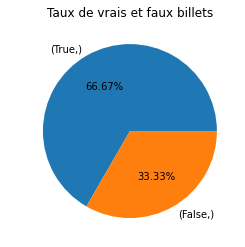

In [5]:
# Taux de vrais / faux billets
billets[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux de vrais et faux billets')
plt.ylabel(' ')
plt.show()

In [6]:
#Val manquantes/doublons
print('Valeurs manquantes :\n', billets.isna().sum())
print()
print('Doublons : ', billets.duplicated().sum())

Valeurs manquantes :
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Doublons :  0


In [7]:
# On regarde les valeurs pour 'margin_low' de 2.98 à 6.9
billets['margin_low'].sort_values().unique()

array([2.98, 3.12, 3.16, 3.24, 3.25, 3.26, 3.28, 3.32, 3.35, 3.39, 3.41,
       3.43, 3.44, 3.45, 3.47, 3.48, 3.49, 3.51, 3.52, 3.53, 3.54, 3.55,
       3.56, 3.57, 3.58, 3.59, 3.6 , 3.61, 3.62, 3.63, 3.64, 3.65, 3.66,
       3.67, 3.68, 3.69, 3.7 , 3.71, 3.72, 3.73, 3.74, 3.75, 3.76, 3.77,
       3.78, 3.79, 3.8 , 3.81, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88,
       3.89, 3.9 , 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99,
       4.  , 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08, 4.09, 4.1 ,
       4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.2 , 4.21,
       4.22, 4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.3 , 4.31, 4.32,
       4.33, 4.34, 4.35, 4.36, 4.37, 4.38, 4.39, 4.4 , 4.41, 4.42, 4.43,
       4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5 , 4.51, 4.52, 4.53, 4.54,
       4.55, 4.56, 4.57, 4.58, 4.59, 4.6 , 4.61, 4.62, 4.63, 4.64, 4.65,
       4.66, 4.67, 4.68, 4.69, 4.7 , 4.71, 4.72, 4.73, 4.74, 4.75, 4.76,
       4.77, 4.78, 4.79, 4.8 , 4.81, 4.82, 4.83, 4.

In [8]:
# On voit une majorité de nan pour les vrais billets
nan = billets.loc[billets['margin_low'].isna()]
nan.head(37)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


<div style="border: 1px solid RGB(51,165,182);" > 
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.2- Imputation des valeurs manquantes </h3>
    

In [9]:
#On va commencer par créer un nouveau df sans les données manquantes:
df = billets.copy()
df_notisna = df.dropna() 
df_notisna.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

### A - Choix des variables explicatives 

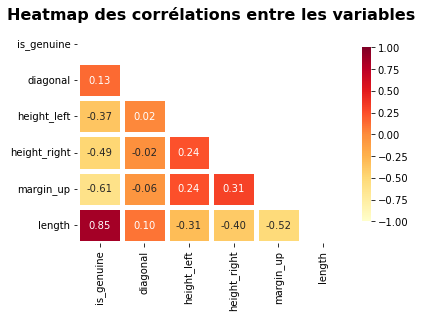

In [10]:
# On va regarder en premier lieu les corrélations entre les variables
billets_drop_margin_low = df_notisna[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']]

corr = billets_drop_margin_low.corr()
mask = np.triu(np.ones_like(corr))

sns.heatmap(corr, vmin=-1, vmax=1, linewidth=5, fmt='.2f', annot=True, cmap="YlOrRd", mask=mask, cbar_kws={"shrink": 0.8})
plt.title('Heatmap des corrélations entre les variables',weight='bold',size=16)
plt.show()

On peut voir une forte corrélation positive entre 'is_genuine' et 'length' :0.85

#### On va vérifier une éventuelle multicolinéarité avec le calcul du VIF (facteur d'inflation de la variance) pour éviter que notre modèle sois biaisé. 


On rappelle les scores du VIF : 

- VIF = 1 : pas de multicolinéarité 
- VIF entre 2 et 5 : légère multicolinéarité 
- VIF > 5 : forte multicolinéarité

In [11]:
# Calcul du VIF
def compute_vif(considered_features):
    X = billets_drop_margin_low[considered_features].astype(int)
    
    # Le calcul du VIF nécessite une constante
    X['intercept'] = 1
    
    # création d'un dataframe pour enregistrer les valeurs du VIF
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# On désigne les variables explicatives potentiellement colinéaires
considered_features = ['is_genuine','diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Application du VIF
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
0,is_genuine,3.39
5,length,2.88
3,height_right,1.24
4,margin_up,1.19
2,height_left,1.17
1,diagonal,1.02


In [12]:
#On enlève 'is_genuine' comme variable explicative car VIF élevé
considered_features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
4,length,1.31
2,height_right,1.17
3,margin_up,1.13
1,height_left,1.12
0,diagonal,1.01


On tombe sur des scores de VIF très bons qui n'expriment pas de multicolinéarité entre nos variables explicatives. On gardera donc ces 5 variables explicatives.

Aussi : 

is_genuine n'aurait pû être sélectionné dans le cadre d'une régression car qualitative

### B - Choix du modèle et modélisation

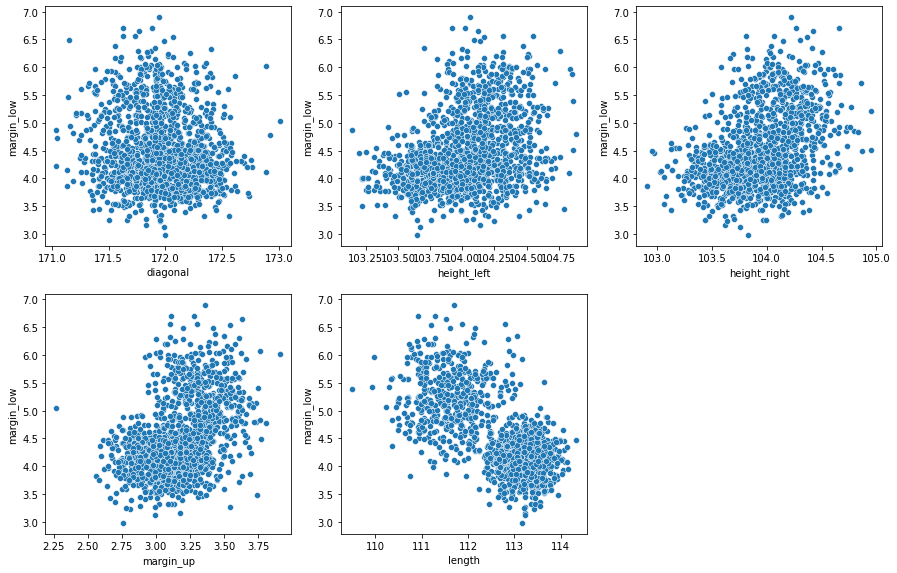

In [13]:
#On regarde la forme de nos données pour le choix de notre modèle
plt.figure(figsize=(15,15))

plt.subplot(331)
sns.scatterplot(data=df_notisna, x='diagonal', y='margin_low')

plt.subplot(332)
sns.scatterplot(data=df_notisna, x='height_left', y='margin_low')

plt.subplot(333)
sns.scatterplot(data=df_notisna, x='height_right', y='margin_low')

plt.subplot(334)
sns.scatterplot(data=df_notisna, x='margin_up', y='margin_low')

plt.subplot(335)
sns.scatterplot(data=df_notisna, x='length', y='margin_low')

plt.show()

Ca ne semble pas vraiment linéaire à vue d'oeil mais on va regarder tout ça de plus prés. On nous a conseillé de réaliser une régression liénaire. Comme il y a plusieurs variables on va partir sur une régression linéaire multiple. (On aurait pu éventuellement utiliser KNNImputer ou un autre type d'imputation.)  


***'Margin_low' = target ou variable à expliquer :  y*** 

***Ttes les autres variables = features ou variables explicatives : X***

Les hypothèses à vérifier pour une régression linéaire multiple sont : 

- Significativité du modèle / des paramètres
- Hypothèse gaussienne 
- Pas de multicolinéarité
- Pas de valeur atypique et influente
- Homoscédasticité des résidus 


D'après les scatterplots précédents, on s'apperçoit que margin up aurait une valeur assez reculée par rapport aux autres. On va l'enlever

<AxesSubplot:ylabel='margin_up'>

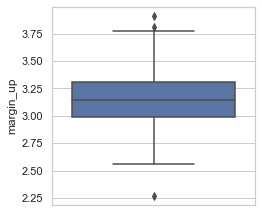

In [14]:
#Exploration des valeurs atypique / influentes de margin up
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')

In [15]:
#On supprime ces valeurs 
df_notisna = df_notisna.loc[(df_notisna['margin_up']>2.50) & (df_notisna['margin_up']<3.76)]

In [16]:
#Création du df sans is_genuine
df_notisna = df_notisna.drop(columns = 'is_genuine') 
df_notisna

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [17]:
# On déclare X et y 
y = df_notisna['margin_low']
X = df_notisna [['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]

In [18]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_notisna).fit()

# On print le summary de la régression linéaire
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     270.2
Date:                Wed, 01 Feb 2023   Prob (F-statistic):          2.26e-204
Time:                        22:31:10   Log-Likelihood:                -987.35
No. Observations:                1457   AIC:                             1987.
Df Residuals:                    1451   BIC:                             2018.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.8298      9.603      2.377   

#### R-squared -- Qualité du modèle
- Le R-squared ou R2 = coefficient de détermination juge de la qualité d’une régression linéaire. Il est compris entre 0 et 100, 100 étant parfait.
Ici, R2= 48%, ce qui n'est pas très élevé.
- Les variables explicatives sélectionnées expliquent près de 50% de la variance de 'margin_low'
- La variable non considérée dans modèle ('is_genuine') explique l'autre moitié de la variance de 'margin_low'

#### Prob (F-statistic) -- relation linéaire or not
- C'est la p-value qui détermine la significativité du modèle y = β1*x1 + β2*x2 + ... + βn*xn
- H0 (hypothèse nulle) : β1= β2 = … = βn = 0
- H1 (hypothèse alternative) : βi ≠ 0
- Si p-value < 5%, H0 est rejetée et le modèle est significatif.
- Ici, la p-value est < 0.05, nous rejetons H0, on peut confirmer qu'il y a une relation linéaire entre 'margin_low' et les variables prédictives.

#### P>|t| -- Variables explicatives significatives
- t est la valeur de la statistique t qui teste si nos variables explicatives sont significatives.
- H0 : coef == 0 pas significative
- H1 : coef != 0 significative
- Pr>|t| est la p-value de ce test. Si p-value < 5%, H0 est rejetée et les coefs sont différents de 0.
- Ici, chacune des P>|t| < 5%. On peut garder toutes nos variables explicatives.

In [19]:
#On regarde les éventuels problème de multicolinéarité:
var = reg_multi.model.exog
[variance_inflation_factor(var, i) for i in np.arange(1,var.shape[1])]

[1.01390889139355,
 1.1351835834247372,
 1.2272240995999313,
 1.400217615776952,
 1.573432107544981]

Tous les coeff sont proches de 1 donc comme l'avait indiqué le VIF au début, nous n'avons pas de problème de multicolinéarité.

In [20]:
#Test d'homoscédasticité des résidus avec test de breuschpagan
_, pval, __, f_pval = sma.stats.diagnostic.het_breuschpagan(reg_multi.resid, var)

print('p value test BreuschPagan:', pval)

p value test BreuschPagan: 1.5610196142613107e-16


H0 (hypothèse nulle) : homoscédasticité

H1 (hypothèse alternative) : hétéroscédasticité

p-value < 0.05, on rejette H0, il y a hétéroscédasticité des résidus. La variance n'est pas constante donc hétéroscédasticité des résidus.

In [21]:
# Test de normalité des résidus avec le test de shapiro
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9866698980331421, pvalue=2.580725633194447e-10)

H0 (hypothèse nulle) : Les résidus suivent une loi normale

H1 (hypothèse alternative) : Les résidus ne suivent pas une loi normale

p-value < 0.05, on rejette H0, les résidus ne suivent pas une loi normale

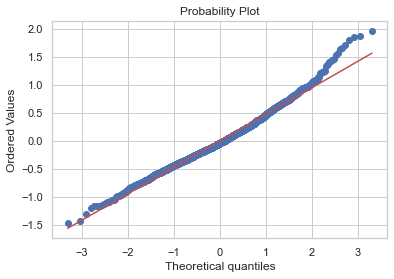

In [22]:
#Visuel de la distribution des résidus selon la droite de Henry qui suit une loi normale
st.probplot(reg_multi.resid, dist="norm", plot=plt);

Assez satisfaisant même si les résidus ne suivent pas parfaitement une loi normale notamment au niveau des extrêmités. 

Conclusion : Dans ce modèle, la distrbution gaussienne + homoscédasticité des résidus n'est pas respectés. Le modèle de regression linéaire multiple est robuste pour les grands échantillons, ce qui est le cas dans notre contexte. Le modèle est capable de supporter des écarts important aux hypothèses homoscédastique et gaussienne.

### C - Prédiction

In [23]:
df.shape
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [24]:
a_predire = df #On reprend notre df avec les val manquantes
margin_low_pred_reg_multi = reg_multi.predict(a_predire)#On prédit les val manquantes
margin_low_pred_reg_multi.head(10)

0   4.80
1   4.13
2   4.12
3   4.16
4   4.58
5   4.34
6   4.42
7   4.26
8   4.29
9   4.17
dtype: float64

In [25]:
#On remplace les val manquantes avec les val prédites grâce à la régression linéaire multiple
billets.loc[billets["margin_low"].isnull(), 'margin_low'] = margin_low_pred_reg_multi
#Vérif
billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [26]:
billets.to_csv('billets_corrige.csv',index=False)

<div style="border: 1px solid RGB(51,165,182);" > 
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.3- Analyse descriptive </h3>

In [27]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,"1,500.00","1,500.00","1,500.00","1,500.00","1,500.00","1,500.00"
mean,171.96,104.03,103.92,4.48,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.02,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


In [28]:
# Moyenne des variables par rapport a is_genuine:
print(billets.groupby(["is_genuine"]).mean())

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False         171.90       104.19        104.14        5.21       3.35  111.63
True          171.99       103.95        103.81        4.12       3.05  113.20


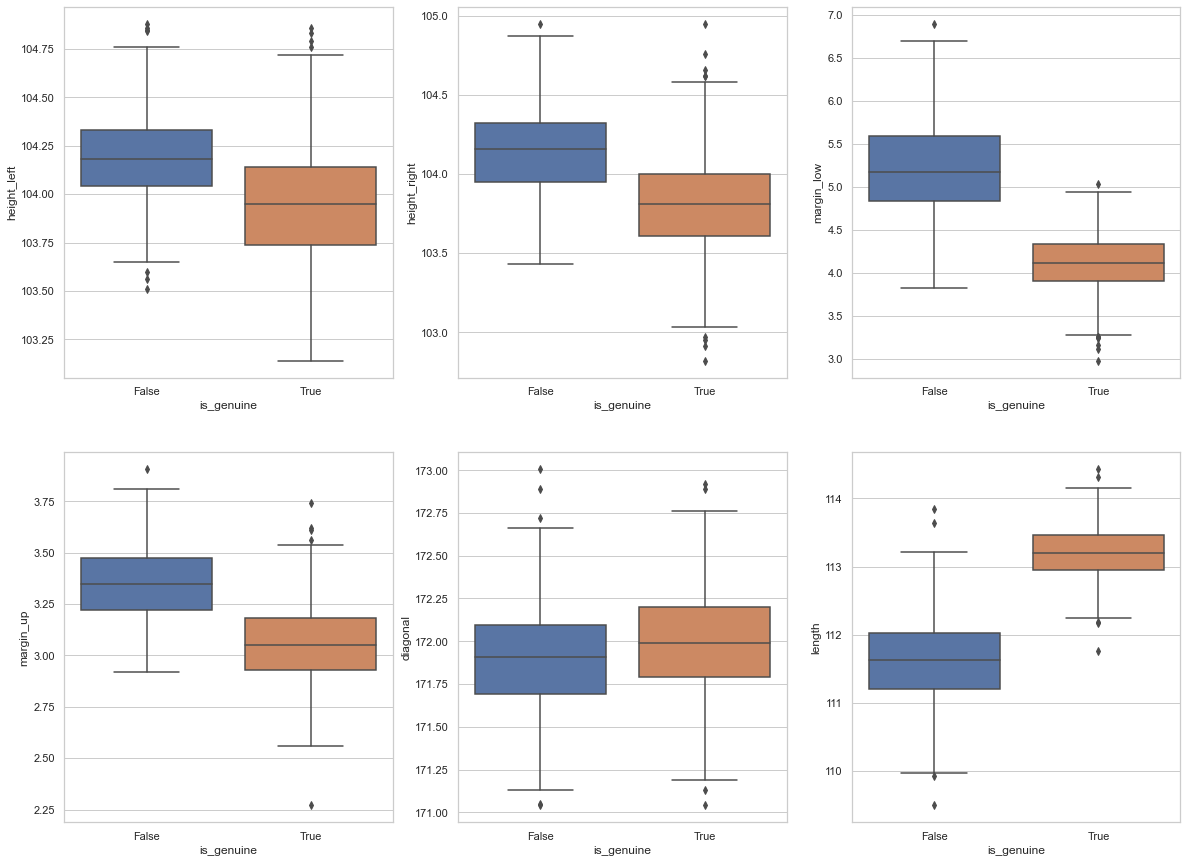

In [29]:
# Distribution des variables par rapport à 'is_genuine'
plt.figure(figsize=(20, 15))
plt.subplot(231)
sns.boxplot(x='is_genuine', y='height_left', data=billets)
plt.subplot(232)
sns.boxplot(x='is_genuine', y='height_right', data=billets)
plt.subplot(233)
sns.boxplot(x='is_genuine', y='margin_low', data=billets)
plt.subplot(234)
sns.boxplot(x='is_genuine', y='margin_up', data=billets)
plt.subplot(235)
sns.boxplot(x='is_genuine', y='diagonal', data=billets)
plt.subplot(236)
sns.boxplot(x='is_genuine', y='length', data=billets)
plt.show()

 On constate que :
 
 - Les variables margin et height ont toutes deux des medianes plus élevées pour les faux billets.
 - La variable length a une médiane basse pour les faux billets.
 - La variable diagonal semble avoir une médiane plus légèrement négative pour les faux billets.

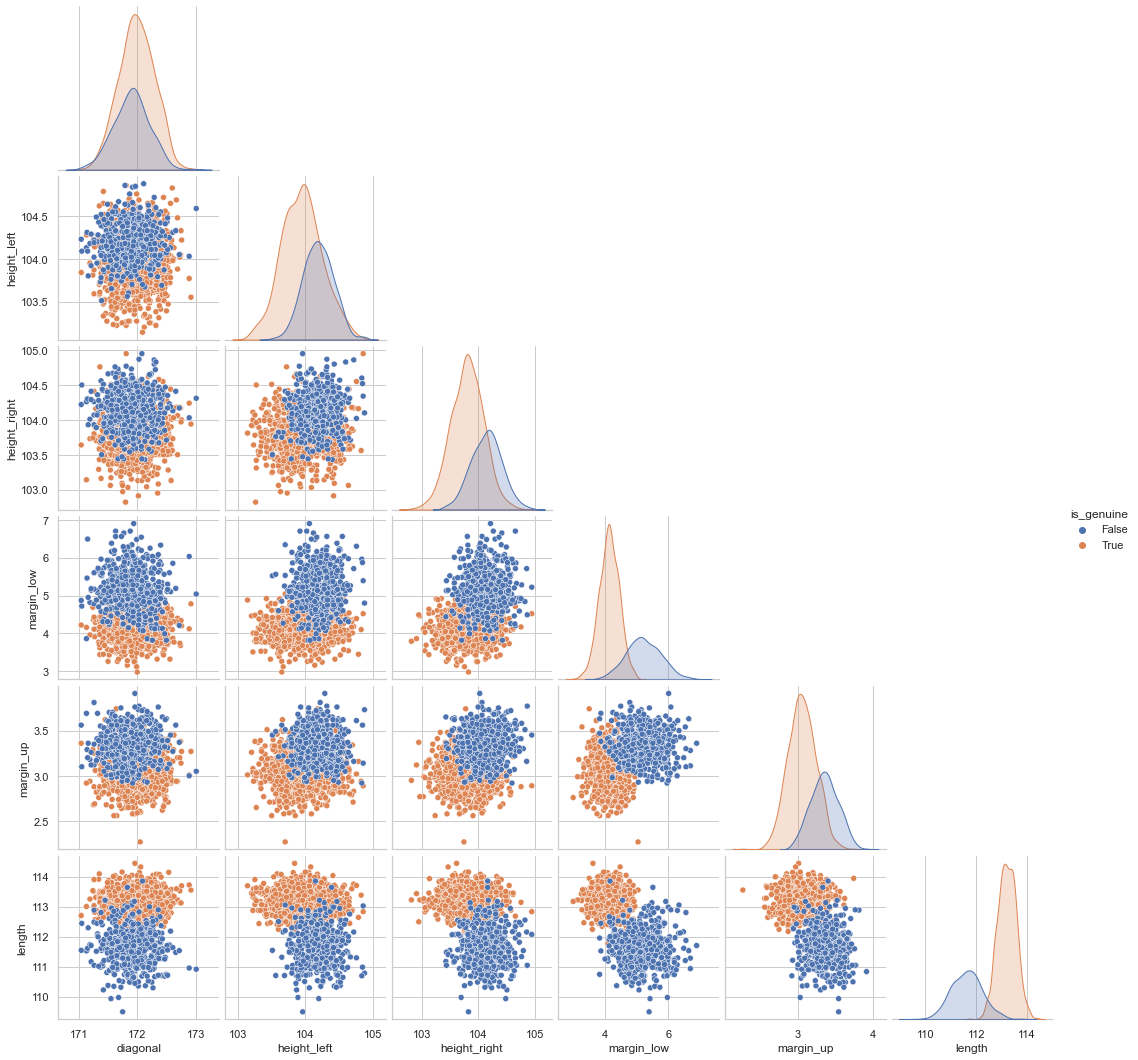

In [30]:
# Pair plot:
sns.pairplot(billets, hue="is_genuine", corner=True)

La densité des variables selon les critères d'un billet vrai ou faux met en évidence une variation plus importante pour les variables suivantes :

  - height_right
  - margin_low
  - margin_up
  - length
  
 Mais surtout pour 'lenght' et 'margin_low'.

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">3 - Modélisation</h2>

On est dans le cas d'une modélisation par classification car y est qualitatitif 

***'is_genuine' = target ou variable à expliquer :  y*** 

***Ttes les autres variables = variables explicatives : X***

In [31]:
#On déclare X (les variables explicatives) et y (la cible)
billets2 = billets.copy()
y = billets2['is_genuine']
X = billets2[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]

In [32]:
#Normalisation des données meme si mm unité mais echelle différentes (ex diago vs marge)
X_scaled = RobustScaler().fit_transform(X)

In [33]:
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,-0.00,-0.03,0.00,0.20,0.04,-0.21
std,0.73,0.73,0.74,0.78,0.72,0.67


In [34]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.36,2.00,2.34,0.25,-0.78,-0.10
1,-1.19,-1.66,-0.59,-0.64,-0.47,0.10
2,1.74,1.07,-0.95,0.11,-0.63,0.15
3,-1.43,-0.32,0.05,-0.81,-0.41,0.42
4,-0.55,0.59,-1.05,-0.32,1.06,-0.32
...,...,...,...,...,...,...
1495,-0.50,0.83,0.57,0.13,-0.16,-1.28
1496,0.55,1.44,1.18,1.13,0.72,-1.52
1497,-0.38,-0.07,0.45,1.41,0.69,-0.77
1498,0.24,0.59,0.32,1.01,1.00,-0.54


In [35]:
#Découpage du data en 2 : 80% entrainement / 20% test grâce à la fct train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=110)

#On rappelle que nos données sont normalisées

# On print les training et testing sets
print('X_train : ')
print(X_train.shape)

print('')
print('y_train : ')
print(y_train.shape)

print('')
print('X_test : ')
print(X_test.shape)
 
print('')
print('y_test : ')
print(y_test.shape)

X_train : 
(1200, 6)

y_train : 
(1200,)

X_test : 
(300, 6)

y_test : 
(300,)


<div style="border: 1px solid RGB(51,165,182);" > 
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">3.1- K-means </h3>

### A - Réduction de dimension avec une ACP

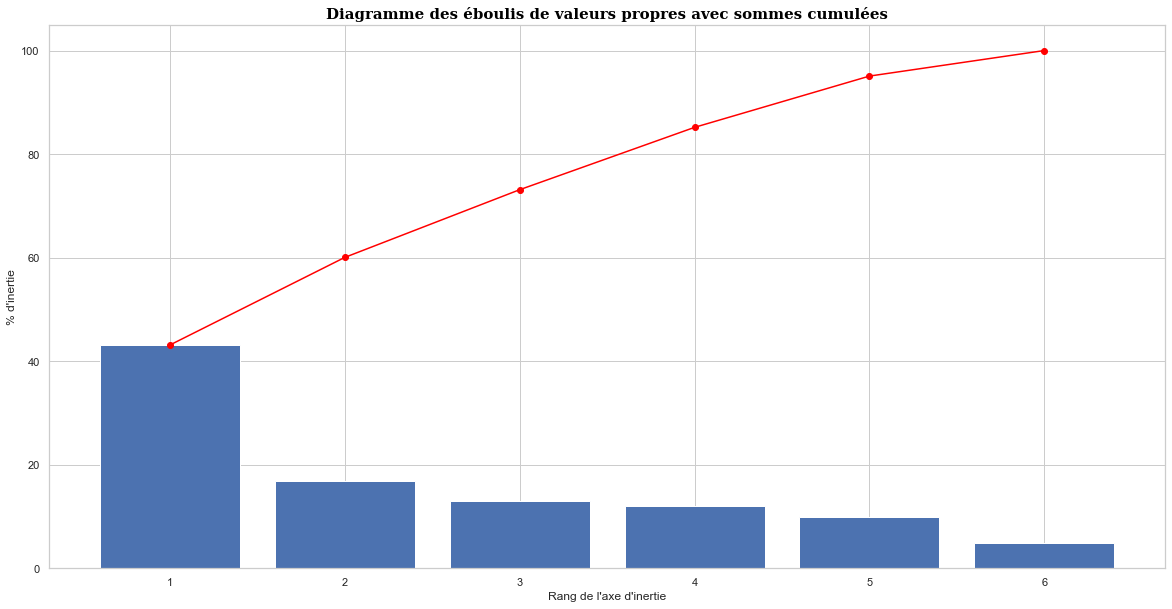

In [36]:
#Avant de commencer le clustering, on va réaliser une ACP dans un but de réduction de dimension et de meilleure compréhension des NC
pca = decomposition.PCA()
X_projected = pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree, )
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("% d'inertie")
plt.title("Diagramme des éboulis de valeurs propres avec sommes cumulées",
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15});


In [37]:
# Variance captée par chaque nouvelle composante
scree = (pca.explained_variance_ratio_*100).round(2)
print('Variance expliquée pour chaque composante',scree)
print()
# Pourcentage de variance expliquée
scree_cum = scree.cumsum().round(2)
print('% variance expliquée cumulée',scree_cum)

print()
#Méthode de Kaiser pour choisir le nb de NC:
a = 100/6 #nb de variable
print("Choix de la NC dont la variance expliquée n'est pas inférieure à " ,round(a,2))

Variance expliquée pour chaque composante [43.11 16.92 13.08 12.05  9.91  4.93]

% variance expliquée cumulée [ 43.11  60.03  73.11  85.16  95.07 100.  ]

Choix de la NC dont la variance expliquée n'est pas inférieure à  16.67


Nous irons donc jusqu'à F2 soit une variance expliquée cumulée de 60.04%

In [38]:
features = X.columns
#On choisit 2 composantes principales.
n_comp = 2
pca = decomposition.PCA(n_components=n_comp)# On crée notre modèle
pca.fit(X_scaled) #On l'entraîne

#Coeff des composantes principales F1 et F2 en fonction des variables 
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
x_list = range(1, n_comp+1)
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.08,0.33,0.41,0.55,0.43,-0.47
F2,0.94,0.32,0.12,-0.09,-0.01,0.05


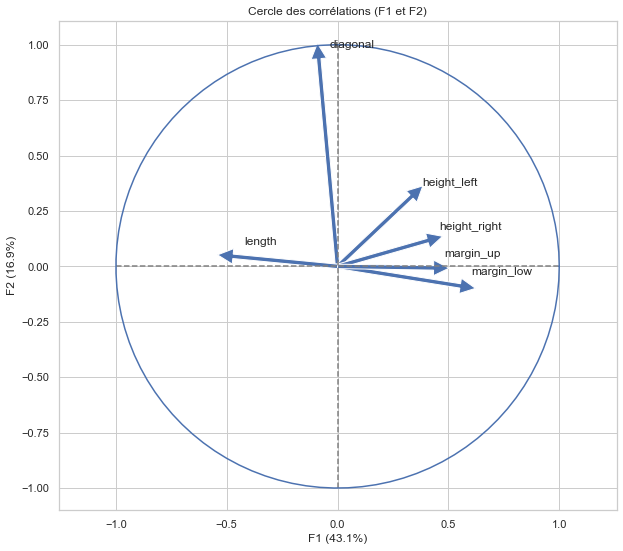

In [39]:
#Cercles de corrélations sur le premier plan factoriel 
x, y = 0,1
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )
    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])  
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

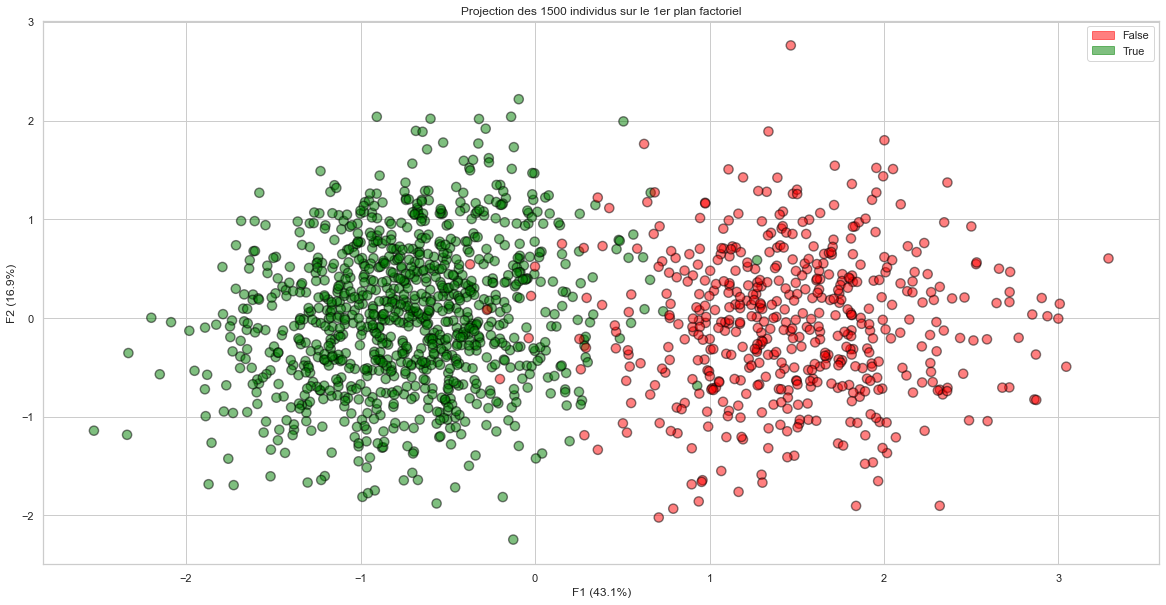

In [40]:
import matplotlib.patches as mpatches
#Nuage des individus sur le premier plan factoriel
X_projected = pca.transform(X_scaled)
y= billets['is_genuine']
colors = ['red', 'green']
# F1 ET F2
plt.figure(figsize=(20, 10))

plt.scatter(X_projected[:,0], X_projected[:, 1], c=y.apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

#Labels et colors des billets 
lab_0 = mpatches.Patch(color='red', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='green', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])


plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.show()

Au niveau du cercle des corrélations :

- On voit que toutes nos variables ne sont pas représentées de la même manière (longueur des flèches), diagonal est parfaitement représentée, les autres variables sont, on peut dire, moyennement bien représentées. 
- Au niveau des angles, on peut voir que margin_low, margin_up et height_right sont très correlées. Lenght étant anticorrelé à ces dernières. 

- F1 : les margins contribuent fortement et le plus à F1 et sont positivement correlées. les qutres sont positivement correlés à F1 dans une moindre mesure. Lenght étant correlé fortement mais négativement à F1, ainsi que diagonal mais dans une moindre mesure (négativement).   
- F2 : Diagonal contribue fortement à F2. 


***F1 = On peut dire toutes les autres variables mais surtout les variables margin***

***F2 = diagonal***


Au niveau du nuage des individus :

On constate 2 clusters bien distincts, avec quelques vrais/faux éparpillés au centre.  
On peut voir également qu'il y aurait quelques potentiels outliers 

### B - KMeans : Choix du nombre de clusters et entrainement

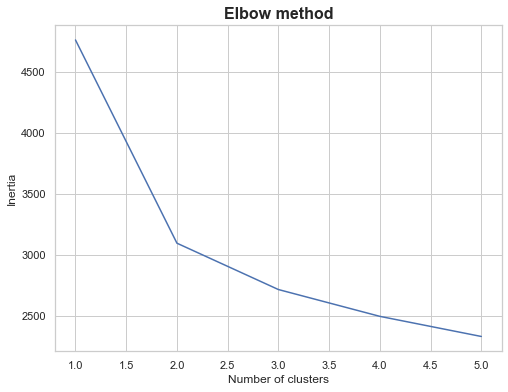

Inertie totale : 2327.76


In [41]:
# On définit une liste vide pour enregistrer les inerties :  
inertia_list = [ ]
# Notre liste de nombres de clusters qu'on souhaite tester : 
k_list = range(1, 6)

# Pour chaque nombre de clusters : 
for k in k_list : 
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    # On entraine
    kmeans.fit(X_scaled)
    # On enregistre l'inertie obtenue : 
    inertia_list.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(8,6))
plt.plot(k_list,inertia_list )
plt.title('Elbow method',weight='bold',size=16)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
print('Inertie totale :',round(kmeans.inertia_,2))

D'après la méthode elbow, on constate bien qu'on a 2 k cluster optimal au niveau du creu : 1 cluster billets vrais / 1 cluster billets faux, ça semble bien logique 


***Cluster 0 = billets vrais / cluster 1 = billets faux***
[[ 0.06285597 -0.23094042 -0.24638493 -0.22421547 -0.27978576  0.18132359]
 [-0.14585629  0.40591887  0.51980603  1.09260473  0.65922237 -1.02598167]]

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')


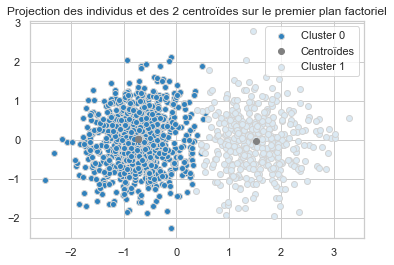

In [42]:
#On instancie un modèle 
kmeans =  KMeans(n_clusters = 2, init = 'k-means++', random_state = 700)
#On entraine le modèle 
kmeans = kmeans.fit(X_train)

# On récupère les centroïdes
centroids = kmeans.cluster_centers_
print()
print('***Cluster 0 = billets vrais / cluster 1 = billets faux***')
print(centroids)
print()
print(X_train.columns)

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=2).fit(X_train[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=2).fit_transform(X_train[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids)


# Graphique:
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[kmeans.labels_==k,0],acp_km[kmeans.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids)))
plt.show()

(voir boxplot) On sait que les faux billets sont négativement corrélés aux variables diagonal et length et positivement corrélés aux autres variables, on peut donc dire que :

- le premier cluster avec les centroïdes regroupe les vrais billets = Cluster 0 - vrais billets
- le deuxième cluster avec les centroïdes regroupe les faux billets = Cluster 1 - faux billets

In [43]:
#Application 
km_pred = kmeans.predict(X_train)
df_cls2 = pd.DataFrame(km_pred, columns=['cluster_km'], dtype=int)
#Intégration des clusters dans notre df
df_cls2 = pd.concat([df_cls2, billets], axis=1, join='inner')
df_cls2.head(10)

,cluster_km,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.46,103.36,103.66,3.77,2.99,113.09
2,1,True,172.69,104.48,103.50,4.40,2.94,113.16
3,0,True,171.36,103.91,103.94,3.62,3.01,113.51
4,0,True,171.73,104.28,103.46,4.04,3.48,112.54
5,0,True,172.17,103.74,104.08,4.42,2.95,112.81
6,0,True,172.34,104.18,103.85,4.58,3.26,112.81
7,1,True,171.88,103.76,104.08,3.98,2.92,113.08
8,0,True,172.47,103.92,103.67,4.00,3.25,112.85
9,0,True,172.47,104.07,104.02,4.04,3.25,113.45


Cela confirme que le cluster 0 correspond aux billets vrais malgré 2 erreurs sur head(10)

In [44]:
# On print la mesure de la précision du modèle sur le training set
train_precision_km = round(adjusted_rand_score(y_train, km_pred), 4)

print("La précision du clustering sur le training set est de (%) {}".format(train_precision_km*100))

La précision du clustering sur le training set est de (%) 93.67


### C - KMeans prediction

In [45]:
# Prédiction pour la mesure de performance : on l'applique au testing set
km_pred = kmeans.predict(X_test)
km_pred = 1-km_pred # inverser les valeur tel que vrai billet=1 et faux billet=0 pour que la lecture se fasse dans le bon sens
km_pred 

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [46]:
# Mesure de la précision du modèle sur le testing set
test_precision_km = round(adjusted_rand_score(y_test, km_pred), 4)
print("La précision du clustering sur le testing set est de (%) {}".format(test_precision_km*100))

La précision du clustering sur le testing set est de (%) 90.79


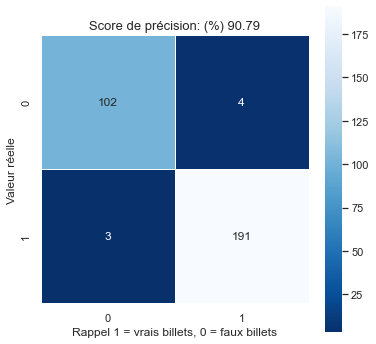

In [47]:
#On regarde la matrice de confusion
cm_km = confusion_matrix(y_test, km_pred)
# On trace le graph 
plt.figure(figsize=(6,6))
sns.heatmap(cm_km, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.xlabel('Rappel 1 = vrais billets, 0 = faux billets');
plt.ylabel('Valeur réelle')
all_sample_title = 'Score de précision: (%) {0}'.format(test_precision_km*100)
plt.title(all_sample_title, size = 13);

On rappelle que en abcisse : 
1 = vrais billets
0 = faux billets

En ordonnée : 
0 = négatif
1 = positive

On a donc ici sur le testing set de 300 billets

TN = 102 billets Vrai faux billets 

FN = 4 billets faux faux billets

TP = 191 billets vrai vrai billets

FP = 3 faux vrai billets

In [48]:
#Specificity = TN / (TN + FP) = 102 / (102+3)
spec_kmeans =  102 / (102+3)
round(spec_kmeans *100,2)

97.14

In [49]:
#Tx d'erreur : (FP+FN)/(TP+TN)+(FN+FP) = (FP+FN)/(P+N)
tx_error =  7/(293+7)
round(tx_error*100,2)

2.33

<div style="border: 1px solid RGB(51,165,182);" > 
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">3.2- Régression logistique </h3>

X et y restent inchangés

Hypothèses à vérifier pour la régression logistique

- Taille de l'échantillon : doit être suffisant. Ici nous avons 1500 valeurs dont 1000 billets vrais et 500 billets faux. C'est donc le cas.
- Significativé des variables : les variables dont la p-value < 0.05 seront gardées car significatives.
- Y binaire : encodage de is_genuine 0 = non occurence, 1 = occurence, c'est ok
- Pas de multicolinéarité pour les variables indépendantes
- Distribution gaussienne

In [50]:
# Encoder la variable is_genuine 0 = non occurence et 1 occurence
billets2['is_genuine'].replace([False,True], [0,1], inplace=True)
print(billets2['is_genuine'].value_counts())
y = billets2['is_genuine']

1    1000
0     500
Name: is_genuine, dtype: int64


### A - Choix des variables

In [51]:
# Regression logistique avec statsmodel pour regarder les variables significatives
X_const = sma.add_constant(X)
reglog = Logit(endog=y , exog= X_const)
reslog = reglog.fit()
print(reslog.summary())

Optimization terminated successfully.
         Current function value: 0.028236
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Wed, 01 Feb 2023   Pseudo R-squ.:                  0.9556
Time:                        22:31:17   Log-Likelihood:                -42.354
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -204.5881    241.715     -0.846      0.397    -678.340     269.164
diagonal         0.067

Le message d'erreur est dû au fait que le modèle apprend trop bien car nos données sont très artificielles avec peu d'erreur.

Au niveau des choix du vériables : On a des variables non-significatives > au seuil alpha 5 %, on recommence la régression sans ces variables (diagonal et height_left).

In [52]:
#On ne garde que les variables significatives :
X = X[["height_right","margin_low", "margin_up", "length"]]
X.head(5)

,height_right,margin_low,margin_up,length
0,104.95,4.52,2.89,112.83
1,103.66,3.77,2.99,113.09
2,103.50,4.40,2.94,113.16
3,103.94,3.62,3.01,113.51
4,103.46,4.04,3.48,112.54


In [53]:
# On recommence la regression logistique:
reglog = Logit(endog=y,exog=X)

# Creation du modele:
model = reglog.fit()

# Resume des resultats:
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.030995
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1496
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 Feb 2023   Pseudo R-squ.:                  0.9513
Time:                        22:31:17   Log-Likelihood:                -46.493
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_right    -5.0134      0.680     -7.376      0.000      -6.345      -3.681
margin_low      -5.865

LLR p-value est inférieure à 0.05, le modèle est significatif dans son ensemble.

Le pseudo R2 montre que notre modèle explique 95% de la variance observée.

In [54]:
# Calcul du VIF pour regarder la multicolinéarité
def compute_vif(considered_features):
    X = billets2[considered_features].astype(int)
    
    # Le calcul du VIF nécessite une constante
    X['intercept'] = 1
    
    # création d'un dataframe pour enregistrer les valeurs du VIF
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# On désigne les variables explicatives potentiellement colinéaires
considered_features = ["height_right","margin_low", "margin_up", "length"]

# Application du VIF
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,length,1.61
1,margin_low,1.49
0,height_right,1.17
2,margin_up,1.13


Pas de multicolinéarité.

Nous avons donc rempli tous les critères des hypothèses à vérifier. 
Sachant que l'hypothèse gaussienne grâce à la taille du dataset nous apporte un modèle suffisamment robuste. 

In [55]:
#Découpage du data en 2 : 80% entrainement / 20% test grâce à la fct train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=150 )

# On print les training et testing sets
print('X_train : ')
print(X_train.shape)

print('')
print('y_train : ')
print(y_train.shape)

print('')
print('X_test : ')
print(X_test.shape)
 
print('')
print('y_test : ')
print(y_test.shape)

X_train : 
(1200, 4)

y_train : 
(1200,)

X_test : 
(300, 4)

y_test : 
(300,)


### B - Train set

In [56]:
#On test avec skicitlearn
model = LogisticRegression() 
model.fit(X_train, y_train)
model_predict = model.predict(X_train)
print('Précision du modèle : ',round(accuracy_score(model_predict,y_train)*100,2))

Précision du modèle :  99.08


### C - prediction sur test set

In [57]:
model = LogisticRegression() 
model.fit(X_test, y_test)
model_predict = model.predict(X_test)
model_predict

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], d

In [58]:
#Score de précision du modèle
preci = round(accuracy_score(model_predict,y_test)*100,2)
print('Précision du modèle : ',preci)

Précision du modèle :  99.0


In [59]:
print(classification_report(y_test, model_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       105
           1       0.99      0.99      0.99       195

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



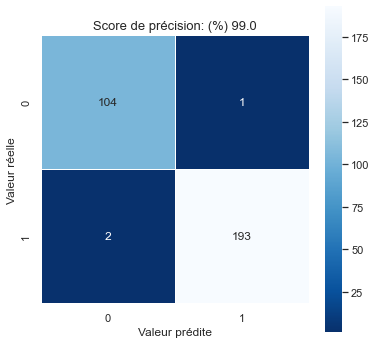

In [60]:
# On imprime la matrice de confusion
cm = confusion_matrix(y_test, model_predict)
# On trace le graph de la matrice de confusion
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.xlabel('Valeur prédite');
plt.ylabel('Valeur réelle');
all_sample_title = 'Score de précision: (%) {0}'.format(preci)
plt.title(all_sample_title, size = 13);

On rappelle que en abcisse : 
0 = faux billets
1 = vrais billets

En ordonnée : 
0 = négatif
1 = positive

On a donc ici sur le testing set de 300 billets

TN = 104 billets Vrai faux billets 

FN = 1 faux faux billets

TP = 193  vrai vrai billets

FP = 2 faux vrai billets

On part du principe que les FP sont les plus importants. La reg Log s'est donc trompé sur 2 faux billets

In [61]:
#specificity : TN / (TN+FP) = 100/(100+2)
specificity = 104/(104+2)
round(specificity*100,2)

98.11

In [62]:
#Tx d'erreur : (FP+FN)/(TP+TN)+(FN+FP) = (FP+FN)/(P+N)
tx_error =  3/(297+3)
round(tx_error*100,2)

1.0

<div style="border: 1px solid RGB(51,165,182);" > 
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">3.3- KNN </h3>

In [63]:
#On reprend y et X avec toutes les variables
X= billets2[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
#Découpage du data en 2 : 80% entrainement / 20% test grâce à la fct train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=150 )

# On print les training et testing sets
print('X_train : ')
print(X_train.shape)

print('')
print('y_train : ')
print(y_train.shape)

print('')
print('X_test : ')
print(X_test.shape)
 
print('')
print('y_test : ')
print(y_test.shape)

X_train : 
(1200, 6)

y_train : 
(1200,)

X_test : 
(300, 6)

y_test : 
(300,)


### A - Comparatif de plusieurs combinaisons de paramètres

In [64]:
#On va créer un modèle de KNN classique avec k voisin au hasard
model = KNeighborsClassifier(1)

On va chercher a voir quel est le meilleur modèle du KNN grâce à GridShearchCV qui comparera plusieurs combinaisons grâce à la technique de cross_validation : On aura le nb de k voisin optimal a choisir ainsi que les meilleurs hyper-paramètres, on évitera ainsi l'overfitting (machine a perdu tt sens de généralisation car a trop voulu se perfectionner sur les données du train set --> On risque un très bon score au train set mais un très mauvais au test set)

In [65]:
#On crée un dictionnaire avec plusieurs hyperparamètres et un nb de 1 a 15 neighbors
param_grid = {'n_neighbors': np.arange(1,15), 'metric':['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5) #On obtient une grille avec plusieurs estimateurs, avec 5split sur notre data train


#On entraine notre grille comme si c'était un estimateur sur le train set
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [66]:
#On regarde celui qui a eu le meilleur score soit 99% c'est très bien
round(grid.best_score_,3)*100

99.0

In [67]:
#On regarde la grille qui a eu les meilleurs paramètres
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 7}

In [68]:
#On sauvegarde ce modèle dans notre modèle
model = grid.best_estimator_

### B - Prédictions

In [69]:
#On l'entraine sur le test set pour avoir un apperçu de sa précision
scoreKNN = round(model.score(X_test, y_test)*100,2)
scoreKNN

99.33

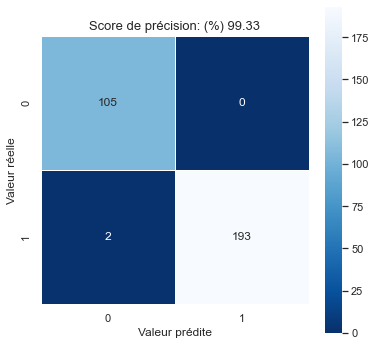

In [70]:
cm = confusion_matrix(y_test, model.predict(X_test)) 
# On regarde le graph de la matrice de confusion
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.xlabel('Valeur prédite');
plt.ylabel('Valeur réelle');
all_sample_title = 'Score de précision: (%) {0}'.format(scoreKNN)
plt.title(all_sample_title, size = 13);

On rappelle que en abcisse : 
0 = faux billets
1 = vrais billets

En ordonnée : 
0 = négatif
1 = positive

On a donc ici sur le testing set de 300 billets

TN = 105 Vrai faux billets 

FN = 0 faux faux billets

TP = 193 vrai vrai billets

FP= 2 faux vrai billets

On part du principe que les FP sont les plus importants. Le KNN s'est donc trompé sur 2 faux billets 

In [71]:
#specificity : TN / (TN+FP) = 100/(100+2)
specificity = 105/(105+2)
round(specificity*100,2)

98.13

In [72]:
#Tx d'erreur : (FP+FN)/(TP+TN)+(FN+FP) = (FP+FN)/(P+N)
tx_error =  2/(298+2)
round(tx_error*100,2)

0.67

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">4 - Prediction sur fichier test</h2>

Si on compare nos 3 modèles, c'est celui du KNN et de la régression logistique où il y a eu le moins d'erreur et un meilleur score (précision et spécificité, tx d'erreur). 

Ce qu'on peut noter :
- Le k-means a eu le plus d'erreurs concernant les FN et les FP et a les scores les plus bas.
- Le KNN a eu autant de FP que la reg log mais son tx d'erreur est + bas a 0.67% contre 1% pour la reglog. De manière générale, c'est ce modèle qui a eu les meilleurs scores de précision, de spécificité et dont le tx d'erreur est le plus bas. 

On va donc choisir le modèle du KNN.

## KNN

In [73]:
#Fichier test avant éval
df_test = pd.read_csv('billets_production.csv',sep=',')
df_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [74]:
def banknotes_identifier(df):
    
    X_final=df.iloc[:,:-1]
    knn=model.predict(X_final.values)
    df['is_genuine_pred']=knn
    
    return df.set_index('id')

In [75]:
banknotes_identifier(df_test)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_pred
id,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,0
A_2,171.87,104.17,104.13,6.00,3.31,112.09,0
A_3,172.00,104.58,104.29,4.99,3.39,111.57,0
A_4,172.49,104.55,104.34,4.44,3.03,113.20,1
A_5,171.65,103.63,103.56,3.77,3.16,113.33,1


On rappelle que ***0 = faux (non occurence)*** et ***1 = vrai (occurence)*** 

In [78]:
#Fichier éval
df_eval = pd.read_csv('billets_test.csv',sep=',')
df_eval

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [79]:
banknotes_identifier(df_eval)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_pred
id,,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19,1
B_2,171.52,104.17,104.03,5.27,3.16,111.82,0
B_3,171.78,103.80,103.75,3.81,3.24,113.39,1
B_4,172.02,104.08,103.99,5.57,3.30,111.10,0
B_5,171.79,104.34,104.37,5.00,3.07,111.87,0
